In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


In [2]:
## read train and test data

train=pd.read_csv("train_2kmZucJ.csv")
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [3]:
train.shape

(7920, 3)

In [4]:
test=pd.read_csv("test_oJQbWVk.csv")
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [5]:
train_cpy=train.copy()
test_cpy=test.copy()

In [6]:
train.label.value_counts()

0    5894
1    2026
Name: label, dtype: int64

In [7]:
# Clean the tweets    


words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there","all","we",
                "one","the","a","an","of","or","in","for","by","on","but","is","in","a","not","with","as",
                "was","if","they","are","this","and","it","have","has","from","at","my","be","by","not","that",
                "to","from","com","org","so","said","from","what","told","over","more","other",
                "have","last","with","this","that","such","when","been","says","will","also","where","why",
                "would","today", "in", "on", "you", "r", "d", "u", "hw","wat", "oly", "s", "b", "ht", 
                "rt", "p","the","th", "n", "was"]


def cleantext(df, words_to_remove = words_remove): 
    
    df['cleaned_tweet'] = df['tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
    df['cleaned_tweet'] = df['cleaned_tweet'].replace("  ", " ")

    ### dont change the original tweet
    # remove emoticons form the tweets
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'<ed>','', regex = True)
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'\B<U+.*>|<U+.*>\B|<U+.*>','', regex = True)
    
    # convert tweets to lowercase
    df['cleaned_tweet'] = df['cleaned_tweet'].str.lower()
    
    #remove user mentions
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'^(@\w+)',"", regex=True)
    
    #remove_symbols
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'[^a-zA-Z0-9]', " ", regex=True)

    #remove punctuations 
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}]+',"", regex = True)

    #remove_URL(x):
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'https.*$', "", regex = True)

    #remove 'amp' in the text
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'amp',"", regex = True)
    
    #remove words of length 1 or 2 
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'\b[a-zA-Z]{1,2}\b','', regex=True)

    #remove extra spaces in the tweet
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'^\s+|\s+$'," ", regex=True)
     
    
    #remove stopwords and words_to_remove
    stop_words = set(stopwords.words('english'))
    mystopwords = [stop_words, "via", words_to_remove]
    
    df['fully_cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in mystopwords]))
    

    return df

#get the processed tweets
train = cleantext(train,words_remove)
test = cleantext(test,words_remove)

In [8]:
train.head()

,id,label,tweet,cleaned_tweet,fully_cleaned_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test,fingerprint pregnancy test
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks ...,finally transparant silicon case thanks uncle ...
2,3,0,We love this! Would you go? #talk #makememorie...,love this would you talk makememories un...,love this would you talk makememories unplug r...
3,4,0,I'm wired I know I'm George I was made that wa...,wired know george was made that way iph...,wired know george was made that way iphone cut...
4,5,1,What amazing service! Apple won't even talk to...,what amazing service apple wont even talk a...,what amazing service apple wont even talk abou...


### Vectorize the tweet

In [9]:
train['tokenized_tweet']=train['fully_cleaned_tweet'].apply(word_tokenize)
test['tokenized_tweet']=test['fully_cleaned_tweet'].apply(word_tokenize)

In [10]:
train.head()

,id,label,tweet,cleaned_tweet,fully_cleaned_tweet,tokenized_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test,fingerprint pregnancy test,"[fingerprint, pregnancy, test]"
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks ...,finally transparant silicon case thanks uncle ...,"[finally, transparant, silicon, case, thanks, ..."
2,3,0,We love this! Would you go? #talk #makememorie...,love this would you talk makememories un...,love this would you talk makememories unplug r...,"[love, this, would, you, talk, makememories, u..."
3,4,0,I'm wired I know I'm George I was made that wa...,wired know george was made that way iph...,wired know george was made that way iphone cut...,"[wired, know, george, was, made, that, way, ip..."
4,5,1,What amazing service! Apple won't even talk to...,what amazing service apple wont even talk a...,what amazing service apple wont even talk abou...,"[what, amazing, service, apple, wont, even, ta..."


In [11]:
# train['tokenized_tweet']

In [12]:
test.head()

,id,tweet,cleaned_tweet,fully_cleaned_tweet,tokenized_tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...,hate the new iphone upgrade wont let downlo...,hate the new iphone upgrade wont let download ...,"[hate, the, new, iphone, upgrade, wont, let, d..."
1,7922,currently shitting my fucking pants. #apple #i...,currently shitting fucking pants apple imac...,currently shitting fucking pants apple imac ca...,"[currently, shitting, fucking, pants, apple, i..."
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t...",like puts some cdroms ipad that possible ...,like puts some cdroms ipad that possible yes b...,"[like, puts, some, cdroms, ipad, that, possibl..."
3,7924,My ipod is officially dead. I lost all my pict...,ipod officially dead lost all pictures and...,ipod officially dead lost all pictures and vid...,"[ipod, officially, dead, lost, all, pictures, ..."
4,7925,Been fighting iTunes all night! I only want th...,been fighting itunes all night only want the...,been fighting itunes all night only want the m...,"[been, fighting, itunes, all, night, only, wan..."


In [13]:
# if word has a digit, remove that word
train['tokenized_tweet']=train['tokenized_tweet'].apply(lambda x: [y for y in x if not any(c.isdigit() for c in y)])

In [14]:
# if word has a digit, remove that word
test['tokenized_tweet']=test['tokenized_tweet'].apply(lambda x: [y for y in x if not any(c.isdigit() for c in y)])

In [15]:
train.head()

,id,label,tweet,cleaned_tweet,fully_cleaned_tweet,tokenized_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test,fingerprint pregnancy test,"[fingerprint, pregnancy, test]"
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks ...,finally transparant silicon case thanks uncle ...,"[finally, transparant, silicon, case, thanks, ..."
2,3,0,We love this! Would you go? #talk #makememorie...,love this would you talk makememories un...,love this would you talk makememories unplug r...,"[love, this, would, you, talk, makememories, u..."
3,4,0,I'm wired I know I'm George I was made that wa...,wired know george was made that way iph...,wired know george was made that way iphone cut...,"[wired, know, george, was, made, that, way, ip..."
4,5,1,What amazing service! Apple won't even talk to...,what amazing service apple wont even talk a...,what amazing service apple wont even talk abou...,"[what, amazing, service, apple, wont, even, ta..."


In [16]:
stemmer = PorterStemmer()

train['tokenized_tweet'] = train['tokenized_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])

In [17]:
test['tokenized_tweet'] = test['tokenized_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])

In [18]:
train.head()

,id,label,tweet,cleaned_tweet,fully_cleaned_tweet,tokenized_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test,fingerprint pregnancy test,"[fingerprint, pregnanc, test]"
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks ...,finally transparant silicon case thanks uncle ...,"[final, transpar, silicon, case, thank, uncl, ..."
2,3,0,We love this! Would you go? #talk #makememorie...,love this would you talk makememories un...,love this would you talk makememories unplug r...,"[love, thi, would, you, talk, makememori, unpl..."
3,4,0,I'm wired I know I'm George I was made that wa...,wired know george was made that way iph...,wired know george was made that way iphone cut...,"[wire, know, georg, wa, made, that, way, iphon..."
4,5,1,What amazing service! Apple won't even talk to...,what amazing service apple wont even talk a...,what amazing service apple wont even talk abou...,"[what, amaz, servic, appl, wont, even, talk, a..."


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
bow_vec=CountVectorizer(max_df=0.7, min_df=2, max_features=1000, stop_words='english')

In [21]:
train['tokenized_tweet']=[" ".join(tokenized_tweet) for tokenized_tweet in train['tokenized_tweet'].values]
test['tokenized_tweet']=[" ".join(tokenized_tweet) for tokenized_tweet in test['tokenized_tweet'].values]

In [22]:
train.head()

,id,label,tweet,cleaned_tweet,fully_cleaned_tweet,tokenized_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test,fingerprint pregnancy test,fingerprint pregnanc test
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks ...,finally transparant silicon case thanks uncle ...,final transpar silicon case thank uncl yay son...
2,3,0,We love this! Would you go? #talk #makememorie...,love this would you talk makememories un...,love this would you talk makememories unplug r...,love thi would you talk makememori unplug rela...
3,4,0,I'm wired I know I'm George I was made that wa...,wired know george was made that way iph...,wired know george was made that way iphone cut...,wire know georg wa made that way iphon cute da...
4,5,1,What amazing service! Apple won't even talk to...,what amazing service apple wont even talk a...,what amazing service apple wont even talk abou...,what amaz servic appl wont even talk about que...


In [23]:
train['count']=train['tokenized_tweet'].str.split().str.len()
test['count']=test['tokenized_tweet'].str.split().str.len()

In [24]:
train['count']=train['count'].astype('category')
test['count']=test['count'].astype('category')

In [25]:
y=train['label']

In [26]:
train.drop(['id','tweet','cleaned_tweet','fully_cleaned_tweet','label'],axis=1,inplace=True)

In [27]:
test.drop(['id','tweet','cleaned_tweet','fully_cleaned_tweet'],axis=1,inplace=True)

In [28]:
train_bow=bow_vec.fit_transform(train['tokenized_tweet'])
test_bow=bow_vec.transform(test['tokenized_tweet'])


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
tfidf_vec=TfidfVectorizer(max_df=0.7, min_df=2,max_features=1000, stop_words='english')

In [31]:
train_tfidf=tfidf_vec.fit_transform(train['tokenized_tweet'])
test_tfidf=tfidf_vec.transform(test['tokenized_tweet'])

In [32]:
### Understanding the common words

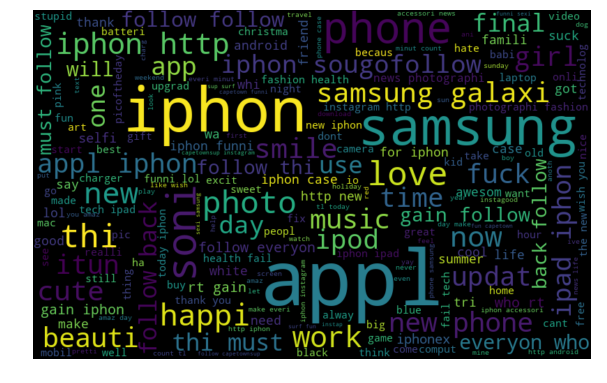

In [33]:

all_words = ' '.join([text for text in train['tokenized_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

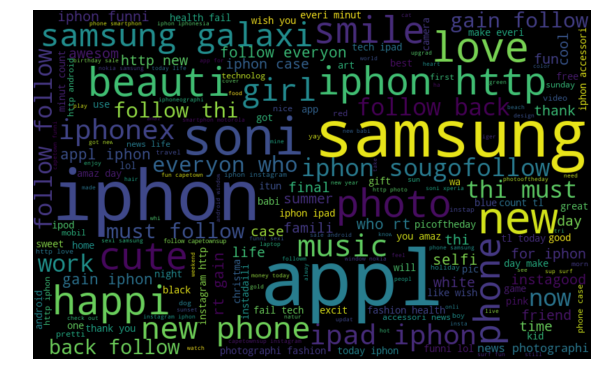

In [34]:
normal_words =' '.join([text for text in train['tokenized_tweet'][y == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

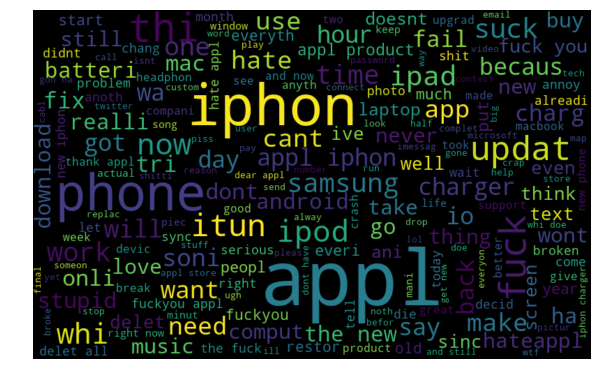

In [35]:
negative_words =' '.join([text for text in train['tokenized_tweet'][y == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Building Model

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


X_train, X_test, y_train, y_test = train_test_split(train_bow, y, test_size=0.3, random_state=42)

lr=LogisticRegression(C=0.5)

lr.fit(X_train,y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
y_pred=lr.predict(X_test)

In [38]:
f1_score(y_test,y_pred)

0.7624489795918367

In [39]:
y_test_pred=lr.predict(test_bow)

In [40]:
submission = pd.concat([test_cpy['id'],pd.DataFrame(y_test_pred, columns=['label'])],1)

In [41]:
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

### Using TFIDF features

In [42]:
X_train, X_test, y_train, y_test = train_test_split(train_tfidf, y, test_size=0.3, random_state=42)

In [43]:
lr.fit(X_train,y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
y_pred=lr.predict(X_test)

In [45]:
f1_score(y_test,y_pred)

0.7186678352322524

In [46]:
y_test_pred=lr.predict(test_tfidf)

In [47]:
submission = pd.concat([test_cpy['id'],pd.DataFrame(y_test_pred, columns=['label'])],1)

In [48]:
submission.to_csv('sub_lreg_tfidf.csv', index=False) # writing data to a CSV file

### Building Light GBM Model

In [49]:
import lightgbm as lgb
lgbm=lgb.LGBMClassifier(reg_alpha=0.05)

In [50]:
lgbm.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.05, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [51]:
y_pred=lgbm.predict(X_test)

In [52]:
f1_score(y_test,y_pred)

0.7462932454695221

In [53]:
y_test_pred=lgbm.predict(test_tfidf)

In [54]:
submission = pd.concat([test_cpy['id'],pd.DataFrame(y_test_pred, columns=['label'])],1)

In [55]:
submission.to_csv('sub_lgbm_tfidf.csv', index=False) # writing data to a CSV file

### Building CATBoost model

In [56]:
import catboost as cb
cb=cb.CatBoostClassifier()

In [57]:
cb.fit(X_train,y_train)

Learning rate set to 0.021407
0:	learn: 0.6769483	total: 301ms	remaining: 5m
1:	learn: 0.6612965	total: 395ms	remaining: 3m 16s
2:	learn: 0.6483359	total: 451ms	remaining: 2m 29s
3:	learn: 0.6359162	total: 515ms	remaining: 2m 8s
4:	learn: 0.6243189	total: 575ms	remaining: 1m 54s
5:	learn: 0.6129825	total: 640ms	remaining: 1m 46s
6:	learn: 0.6015875	total: 698ms	remaining: 1m 39s
7:	learn: 0.5915900	total: 759ms	remaining: 1m 34s
8:	learn: 0.5826469	total: 822ms	remaining: 1m 30s
9:	learn: 0.5734839	total: 881ms	remaining: 1m 27s
10:	learn: 0.5644552	total: 942ms	remaining: 1m 24s
11:	learn: 0.5577722	total: 1.02s	remaining: 1m 24s
12:	learn: 0.5494698	total: 1.08s	remaining: 1m 22s
13:	learn: 0.5408466	total: 1.15s	remaining: 1m 20s
14:	learn: 0.5342643	total: 1.22s	remaining: 1m 19s
15:	learn: 0.5275429	total: 1.28s	remaining: 1m 18s
16:	learn: 0.5237416	total: 1.34s	remaining: 1m 17s
17:	learn: 0.5180276	total: 1.41s	remaining: 1m 17s
18:	learn: 0.5118445	total: 1.47s	remaining: 1m 1

159:	learn: 0.3441854	total: 14.7s	remaining: 1m 17s
160:	learn: 0.3436429	total: 14.8s	remaining: 1m 17s
161:	learn: 0.3432174	total: 14.9s	remaining: 1m 17s
162:	learn: 0.3425458	total: 15.1s	remaining: 1m 17s
163:	learn: 0.3421961	total: 15.2s	remaining: 1m 17s
164:	learn: 0.3418852	total: 15.3s	remaining: 1m 17s
165:	learn: 0.3412406	total: 15.5s	remaining: 1m 17s
166:	learn: 0.3409315	total: 15.6s	remaining: 1m 17s
167:	learn: 0.3405627	total: 15.9s	remaining: 1m 18s
168:	learn: 0.3402097	total: 16s	remaining: 1m 18s
169:	learn: 0.3398066	total: 16.2s	remaining: 1m 18s
170:	learn: 0.3394811	total: 16.2s	remaining: 1m 18s
171:	learn: 0.3390436	total: 16.3s	remaining: 1m 18s
172:	learn: 0.3386168	total: 16.4s	remaining: 1m 18s
173:	learn: 0.3379846	total: 16.4s	remaining: 1m 18s
174:	learn: 0.3375144	total: 16.5s	remaining: 1m 17s
175:	learn: 0.3372636	total: 16.6s	remaining: 1m 17s
176:	learn: 0.3369577	total: 16.7s	remaining: 1m 17s
177:	learn: 0.3366680	total: 16.8s	remaining: 1m

316:	learn: 0.3004089	total: 29.7s	remaining: 1m 3s
317:	learn: 0.3002576	total: 29.8s	remaining: 1m 3s
318:	learn: 0.3000211	total: 29.9s	remaining: 1m 3s
319:	learn: 0.2998783	total: 30.1s	remaining: 1m 3s
320:	learn: 0.2997408	total: 30.2s	remaining: 1m 3s
321:	learn: 0.2995008	total: 30.4s	remaining: 1m 3s
322:	learn: 0.2993350	total: 30.5s	remaining: 1m 3s
323:	learn: 0.2990185	total: 30.6s	remaining: 1m 3s
324:	learn: 0.2987107	total: 30.8s	remaining: 1m 3s
325:	learn: 0.2985454	total: 30.9s	remaining: 1m 3s
326:	learn: 0.2983018	total: 30.9s	remaining: 1m 3s
327:	learn: 0.2980847	total: 31.1s	remaining: 1m 3s
328:	learn: 0.2979315	total: 31.2s	remaining: 1m 3s
329:	learn: 0.2977366	total: 31.3s	remaining: 1m 3s
330:	learn: 0.2975220	total: 31.4s	remaining: 1m 3s
331:	learn: 0.2974082	total: 31.6s	remaining: 1m 3s
332:	learn: 0.2972224	total: 31.7s	remaining: 1m 3s
333:	learn: 0.2969789	total: 31.9s	remaining: 1m 3s
334:	learn: 0.2968610	total: 32s	remaining: 1m 3s
335:	learn: 0.

475:	learn: 0.2708849	total: 42.7s	remaining: 47s
476:	learn: 0.2706959	total: 42.8s	remaining: 46.9s
477:	learn: 0.2706087	total: 42.9s	remaining: 46.8s
478:	learn: 0.2704415	total: 43s	remaining: 46.7s
479:	learn: 0.2703323	total: 43s	remaining: 46.6s
480:	learn: 0.2701494	total: 43.1s	remaining: 46.5s
481:	learn: 0.2700356	total: 43.2s	remaining: 46.4s
482:	learn: 0.2699104	total: 43.2s	remaining: 46.3s
483:	learn: 0.2697453	total: 43.3s	remaining: 46.1s
484:	learn: 0.2695815	total: 43.4s	remaining: 46s
485:	learn: 0.2694224	total: 43.4s	remaining: 45.9s
486:	learn: 0.2691977	total: 43.5s	remaining: 45.8s
487:	learn: 0.2689908	total: 43.6s	remaining: 45.7s
488:	learn: 0.2688315	total: 43.7s	remaining: 45.6s
489:	learn: 0.2685408	total: 43.7s	remaining: 45.5s
490:	learn: 0.2684141	total: 43.8s	remaining: 45.4s
491:	learn: 0.2682400	total: 43.9s	remaining: 45.3s
492:	learn: 0.2679662	total: 44s	remaining: 45.2s
493:	learn: 0.2677827	total: 44s	remaining: 45.1s
494:	learn: 0.2677014	to

635:	learn: 0.2457376	total: 59.2s	remaining: 33.9s
636:	learn: 0.2456958	total: 59.3s	remaining: 33.8s
637:	learn: 0.2455685	total: 59.3s	remaining: 33.7s
638:	learn: 0.2454466	total: 59.4s	remaining: 33.6s
639:	learn: 0.2452499	total: 59.5s	remaining: 33.5s
640:	learn: 0.2450325	total: 59.6s	remaining: 33.4s
641:	learn: 0.2448759	total: 59.6s	remaining: 33.3s
642:	learn: 0.2447097	total: 59.7s	remaining: 33.2s
643:	learn: 0.2445172	total: 59.8s	remaining: 33s
644:	learn: 0.2444776	total: 59.9s	remaining: 32.9s
645:	learn: 0.2444208	total: 59.9s	remaining: 32.8s
646:	learn: 0.2443796	total: 1m	remaining: 32.7s
647:	learn: 0.2442741	total: 1m	remaining: 32.6s
648:	learn: 0.2440589	total: 1m	remaining: 32.5s
649:	learn: 0.2439039	total: 1m	remaining: 32.5s
650:	learn: 0.2438633	total: 1m	remaining: 32.4s
651:	learn: 0.2437410	total: 1m	remaining: 32.3s
652:	learn: 0.2437009	total: 1m	remaining: 32.2s
653:	learn: 0.2435364	total: 1m	remaining: 32.1s
654:	learn: 0.2433561	total: 1m	remain

794:	learn: 0.2255848	total: 1m 15s	remaining: 19.4s
795:	learn: 0.2254329	total: 1m 15s	remaining: 19.3s
796:	learn: 0.2253997	total: 1m 15s	remaining: 19.2s
797:	learn: 0.2252653	total: 1m 15s	remaining: 19.1s
798:	learn: 0.2252359	total: 1m 15s	remaining: 19s
799:	learn: 0.2250634	total: 1m 15s	remaining: 18.9s
800:	learn: 0.2249157	total: 1m 15s	remaining: 18.8s
801:	learn: 0.2247770	total: 1m 15s	remaining: 18.7s
802:	learn: 0.2247295	total: 1m 15s	remaining: 18.6s
803:	learn: 0.2246468	total: 1m 16s	remaining: 18.5s
804:	learn: 0.2245234	total: 1m 16s	remaining: 18.4s
805:	learn: 0.2244899	total: 1m 16s	remaining: 18.3s
806:	learn: 0.2243504	total: 1m 16s	remaining: 18.3s
807:	learn: 0.2241974	total: 1m 16s	remaining: 18.2s
808:	learn: 0.2240704	total: 1m 16s	remaining: 18.1s
809:	learn: 0.2239106	total: 1m 16s	remaining: 18s
810:	learn: 0.2237920	total: 1m 16s	remaining: 17.9s
811:	learn: 0.2237189	total: 1m 16s	remaining: 17.8s
812:	learn: 0.2235941	total: 1m 16s	remaining: 17.

950:	learn: 0.2103542	total: 1m 30s	remaining: 4.64s
951:	learn: 0.2102376	total: 1m 30s	remaining: 4.55s
952:	learn: 0.2101009	total: 1m 30s	remaining: 4.46s
953:	learn: 0.2100747	total: 1m 30s	remaining: 4.37s
954:	learn: 0.2100481	total: 1m 30s	remaining: 4.27s
955:	learn: 0.2098853	total: 1m 30s	remaining: 4.18s
956:	learn: 0.2097654	total: 1m 30s	remaining: 4.09s
957:	learn: 0.2096572	total: 1m 31s	remaining: 3.99s
958:	learn: 0.2096311	total: 1m 31s	remaining: 3.9s
959:	learn: 0.2094993	total: 1m 31s	remaining: 3.81s
960:	learn: 0.2093622	total: 1m 31s	remaining: 3.71s
961:	learn: 0.2092998	total: 1m 31s	remaining: 3.62s
962:	learn: 0.2092587	total: 1m 31s	remaining: 3.52s
963:	learn: 0.2091129	total: 1m 31s	remaining: 3.43s
964:	learn: 0.2090017	total: 1m 31s	remaining: 3.33s
965:	learn: 0.2088567	total: 1m 32s	remaining: 3.24s
966:	learn: 0.2087451	total: 1m 32s	remaining: 3.14s
967:	learn: 0.2086291	total: 1m 32s	remaining: 3.05s
968:	learn: 0.2086014	total: 1m 32s	remaining: 

In [58]:
y_pred=cb.predict(X_test)

In [59]:
f1_score(y_test,y_pred)

0.725085910652921

In [60]:
y_test_pred=cb.predict(test_tfidf)

In [61]:
submission = pd.concat([test_cpy['id'],pd.DataFrame(y_test_pred, columns=['label'])],1)

In [62]:
submission.to_csv('sub_cb_tfidf.csv', index=False) # writing data to a CSV file

### XGBOOST

In [63]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [64]:
xgb=XGBClassifier()

In [65]:
params={'colsample_bytree': [0.7], 'learning_rate': [0.1], 'max_depth': [7], 'min_child_weight': [4],
        'n_estimators': [100],'objective': ['reg:logistic'], 'subsample': [0.6], 'verbosity': [1]}

In [66]:
from sklearn.model_selection import GridSearchCV
xgb1 = GridSearchCV(xgb,
                    params,
                    cv = 3,
                    n_jobs = 5,
                    verbose=True)


In [67]:
xgb1.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:   10.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1], 'max_depth': [7], 'min_child_weight': [4], 'n_estimators': [100], 'objective': ['reg:logistic'], 'subsample': [0.6], 'verbosity': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [68]:
y_pred=xgb1.predict(X_test)

In [69]:
f1_score(y_test,y_pred)

0.7004444444444444

In [70]:
y_test_pred=xgb1.predict(test_tfidf)

In [71]:
submission = pd.concat([test_cpy['id'],pd.DataFrame(y_test_pred, columns=['label'])],1)

In [72]:
submission.to_csv('sub_xgb_tfidf.csv', index=False) # writing data to a CSV file

In [76]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()

In [77]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [78]:
y_pred=dt.predict(X_test)

In [79]:
f1_score(y_test,y_pred)

0.6853146853146853

In [80]:
y_test_pred=dt.predict(test_tfidf)

In [81]:
submission = pd.concat([test_cpy['id'],pd.DataFrame(y_test_pred, columns=['label'])],1)

In [82]:
submission.to_csv('sub_dt_tfidf.csv', index=False) # writing data to a CSV file